# Prediction of Precipitation

In [7]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [13]:
all = pd.read_csv("temp_adj.csv")
#future = pd.read_csv("X of 2023.csv")
#future

future = pd.read_csv("temp_all.csv")
X_future = future[['Anomaly','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Maximun Temperature']]



## XGboost

{'n_estimators': 400, 'max_depth': None, 'max_learning_rate': [0.1, 0.3, 0.5]} best_mse 0.02227756599641272 0.0995334906527038 best_ratio 10 best_r_2 0.9997228542255037
[10:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_learning_rate" } are not used.



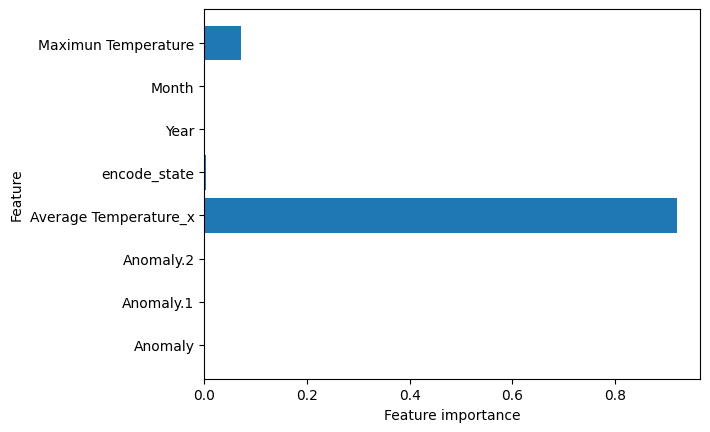

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,r2_score


X = all[['Anomaly','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Maximun Temperature']]
y = all['Minimum Temperature']
dic = {0:'COLORADO',
 1:'KANSAS',
 2:'MINNESOTA',
 3:'MONTANA',
 4:'NEBRASKA',
 5:'NORTH DAKOTA',
 6:'OKLAHOMA',
 7:'SOUTH DAKOTA',
 8:'TEXAS'}



n_estimators = [100,400]  # Number of trees
max_depth = [None,10]
learning_rate = [0.1, 0.3, 0.5]


best_mse = float('inf')
best_params = {}


for ratio in range(10,100,10):
    for estimators in n_estimators:
        for depth in max_depth:
            for rate in learning_rate:
            
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(ratio/100), random_state=71)
                # 初始化回歸器並設定參數

                params = {
                    'learning_rate': rate,  # 調整的第一個參數
                    'n_estimators': estimators,
                    'max_depth': depth,  # 調整的第二個參數
                    'random_state': 71
                }

                regressor = xgb.XGBRegressor(**params)
                
                # 訓練模型
                regressor.fit(X_train, y_train)
                
                # 預測測試集
                y_pred = regressor.predict(X_test)
                y_pred_train = regressor.predict(X_train)

                
               # 計算均方誤差 
                train_mse = mean_squared_error(y_pred_train, y_train)
                
                mse = mean_squared_error(y_test, y_pred)
                r_2= r2_score(y_test, y_pred)
                # 如果得到更好的結果，則更新最佳參數和最佳均方誤差
                if mse < best_mse:
                    best_mse = mse
                    best_r_2 = r_2
                    best_mse_train = train_mse
                    best_params = {
                        
                        'n_estimators': estimators,
                        'max_depth': depth,
                        'max_learning_rate': learning_rate
                    }
                    best_ratio = ratio

print(best_params,'best_mse',best_mse_train,best_mse,'best_ratio',best_ratio,'best_r_2',best_r_2)



regressor = xgb.XGBRegressor(**best_params)
            
# 訓練模型
regressor.fit(X_train, y_train)

y_Fpred = regressor.predict(X_future)

# 計算均方誤差
#mse = mean_squared_error(y_future, y_Fpred)


#print('Precipitatio_mse',mse)

def plot_feature_importances(model):
    n_features = ['Anomaly','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Maximun Temperature']
    plt.barh(n_features, model.feature_importances_, align='center')
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()


plot_feature_importances(regressor)

data_list = y_Fpred.tolist()

data = np.zeros((len(data_list),4))

for i in range(len(data_list)):
    data[i,0] = data_list[i]

for i in range(len(data_list)):
    data[i,1] = future['encode_state'][i]

for i in range(len(data_list)):
    data[i,2] = future['Year'][i]

for i in range(len(data_list)):
    data[i,3] = future['Month'][i]




columns = ['forecast','encode_state','Year','Month']
result = pd.DataFrame(columns=columns, data=data)
result.to_csv('forecast_XGboost_min.csv',encoding = 'gbk')

